In [14]:
import deepxde as dde
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from deepxde.callbacks import ModelCheckpoint
from deepxde.callbacks import Callback
from matplotlib.animation import FuncAnimation
import matplotlib.animation as animation

In [15]:
# Set random seed
seed = 0
np.random.seed(seed)
tf.random.set_seed(seed)
dde.backend.tf.random.set_random_seed(seed)

# Set hyperparameters
n_output = 3 # postition (x), theta, force on cart (u_norm)

num_domain = 1000

n_adam = 5000

lr = 3e-3 # for Adam
loss_weights = [2., 2., 1., 1., 1., 1, 1., 20.]

# Set physical parameters
tmin, tmax = 0.0, 10.0
# xmin, xmax = -5.0, 5.0
target = np.pi # cos(theta) should be close to 180 degrees

# Define constants
M = 2 # Mass of the cart
m = 1 # Mass of the pendulum
b = 0.1 # Friction coefficient
I = 0.33 # Moment of inertia
g = -9.8 # Gravity
l = 1 # Length of the pendulum
force_max = 0.5  # Maximum force

In [16]:
class Custom_BC(dde.icbc.BC):
    def __init__(self, geom, func, on_boundary, component=0):
        super().__init__(geom, on_boundary, component)
        self.func = dde.icbc.boundary_conditions.npfunc_range_autocache(dde.utils.return_tensor(func))
        
    def error(self, X, inputs, outputs, beg, end, aux_var=None):
        # beg and end specify the current batch range
        values = self.func(X, beg, end, aux_var)
        theta = outputs[:, 1:2]
        goal = theta
        return (goal[beg:end, self.component:self.component + 1] - values) ** 2

In [17]:
def ode(t, u):
    x, theta, force_norm = u[:, 0:1], u[:, 1:2], tf.tanh(u[:, 2:3])
    force = force_max * force_norm
    x_dot = dde.grad.jacobian(x, t)
    theta_dot = dde.grad.jacobian(theta, t)
    x_ddot = dde.grad.jacobian(x_dot, t)
    theta_ddot = dde.grad.jacobian(theta_dot, t)

    denominator = I * (M + m) + M * m * l * l

    res1 = x_ddot - (((-(I + m * l * l) * b * x_dot) + (m * m * g * l * l * theta) + ((I + m * l * l) * force)) / denominator)
    res2 = theta_ddot - (((-m * b * l * theta_dot) + (m * g * (M + m) * l * theta) +( m * l * force)) / denominator)

    return [res1, res2]

In [18]:
def initial(_, on_initial):
    return on_initial

def boundary_left(t, on_boundary):
    '''
        on_boundary is passed here by deepxde and it serves as an intial filter which tells if a point lies on the boundary or not

        np.isclose(t[0], tmin) checks if the point is on the left boundary or not and this is a second filter
    '''

    return on_boundary * np.isclose(t[0], tmin)

def boundary_right(t, on_boundary):
    '''
        on_boundary is passed here by deepxde and it serves as an intial filter which tells if a point lies on the boundary or not

        np.isclose(t[0], tmax) checks if the point is on the right boundary or not and this is a second filter
    '''

    return on_boundary * np.isclose(t[0], tmax)

In [19]:
geom = dde.geometry.TimeDomain(tmin, tmax)

# INITIAL CONDITIONS
position_initial = dde.icbc.IC(geom, lambda t: np.array([0.]), initial, component=0) # posittion = 0 at time = 0
theta_initial = dde.icbc.IC(geom, lambda t: np.array([0.]), initial, component=1) # theta = 0 at time = 0
force_initial = dde.icbc.IC(geom, lambda t: np.array([0.]), initial, component=2) # force = 10 at time = 0

# NEUMANN CONDITIONS
velocity_initial = dde.icbc.NeumannBC(geom, lambda t: np.array([0.]), boundary_left, component=0) # cart velocity = 0 at time = 0
angular_velocity_initial = dde.icbc.NeumannBC(geom, lambda t: np.array([0.]), boundary_left, component=1) # angular velocity 1 = 0 at time = 0

# CUSTOM BOUNDARY CONDITIONS - GOAL AND POSITION RANGE
goal = Custom_BC(geom, lambda t: np.array([target]), boundary_right) # custom ICBC

losses = [position_initial, theta_initial, force_initial, velocity_initial, angular_velocity_initial, goal]

data = dde.data.PDE(geom, ode, losses, num_domain=num_domain, num_boundary=50)
# dataset size here will be 1002 (1000 domain + 2 boundary)

In [20]:
net = dde.nn.FNN([1] + [256] * 3 + [n_output], "tanh", "Glorot normal")

In [21]:
resampler = dde.callbacks.PDEPointResampler(period=500)

In [22]:
model = dde.Model(data, net)
model.compile("adam", lr=lr, loss_weights=loss_weights)

Compiling model...
Building feed-forward neural network...
'build' took 0.042237 s



'compile' took 0.383271 s



In [23]:
model_checkpoint = ModelCheckpoint(
    filepath='checkpoints/best_model.ckpt',  # Path to save the model file
    monitor='test loss',          # Monitor the validation loss
    save_better_only=True          # Only save when the monitored quantity (val_loss) has improved
)

In [24]:
print("Residual 1 | Residual 2 | Initial Position | Initial Theta | Initial Force | Initial Velocity | Initial Angular Velocity | Goal")
losshistory, train_state = model.train(display_every=50, iterations=n_adam, callbacks=[resampler, model_checkpoint])

Residual 1 | Residual 2 | Initial Position | Initial Theta | Initial Force | Initial Velocity | Initial Angular Velocity | Goal
Training model...

Step      Train loss                                                                          Test loss                                                                           Test metric
0         [4.98e+00, 4.26e+01, 0.00e+00, 0.00e+00, 0.00e+00, 4.71e-02, 2.34e-02, 4.00e+03]    [4.98e+00, 4.26e+01, 0.00e+00, 0.00e+00, 0.00e+00, 4.71e-02, 2.34e-02, 4.00e+03]    []  
INFO:tensorflow:checkpoints/best_model.ckpt-1.ckpt is not in all_model_checkpoint_paths. Manually adding it.
50        [1.28e+01, 1.23e+02, 1.57e-03, 6.54e-02, 2.01e-01, 7.34e-03, 1.58e-01, 1.90e+02]    [1.28e+01, 1.23e+02, 1.57e-03, 6.54e-02, 2.01e-01, 7.34e-03, 1.58e-01, 1.90e+02]    []  
INFO:tensorflow:checkpoints/best_model.ckpt-50.ckpt is not in all_model_checkpoint_paths. Manually adding it.
100       [1.41e+01, 1.41e+02, 2.40e-04, 4.23e-04, 5.45e-02, 9.74e-03, 8.59e-0

## Getting the predictions for time = 0 to time = 10 at intervals of 0.01

In [29]:
extracted_number = 0
with open("checkpoints/checkpoint", "r") as file:
    for line in file:
        if "best_model" in line:
            extracted_number = int(line.split('-')[-1].split('.')[0])
            break

extracted_number

5000

INFO:tensorflow:Restoring parameters from checkpoints/best_model.ckpt-5000.ckpt


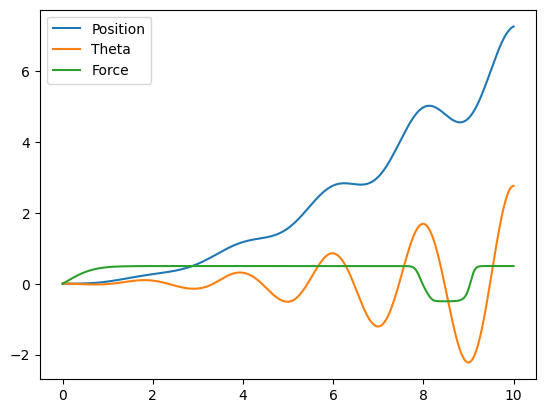

In [30]:
model.restore(save_path=f'checkpoints/best_model.ckpt-{extracted_number}.ckpt')

t = np.linspace(tmin, tmax, 1000)
predictions = model.predict(np.array([t]).T)
predictions[:, 2] = np.tanh(predictions[:, 2]) * force_max

plt.plot(t, predictions[:, 0], label="Position")
plt.plot(t, predictions[:, 1], label="Theta")
plt.plot(t, predictions[:, 2], label="Force")
plt.legend()
plt.show()

In [31]:
# np.save('single_inverted_cart_outputs.npy', predictions)
predictions

array([[ 7.5936317e-04,  1.0063284e-02, -6.5738667e-04],
       [ 7.5721741e-04,  9.6481377e-03,  6.7938631e-03],
       [ 7.5078011e-04,  9.2218453e-03,  1.4257924e-02],
       ...,
       [ 7.2538652e+00,  2.7575235e+00,  4.9999964e-01],
       [ 7.2613926e+00,  2.7615466e+00,  4.9999967e-01],
       [ 7.2680235e+00,  2.7628117e+00,  4.9999970e-01]], dtype=float32)

## Creating animation of the system

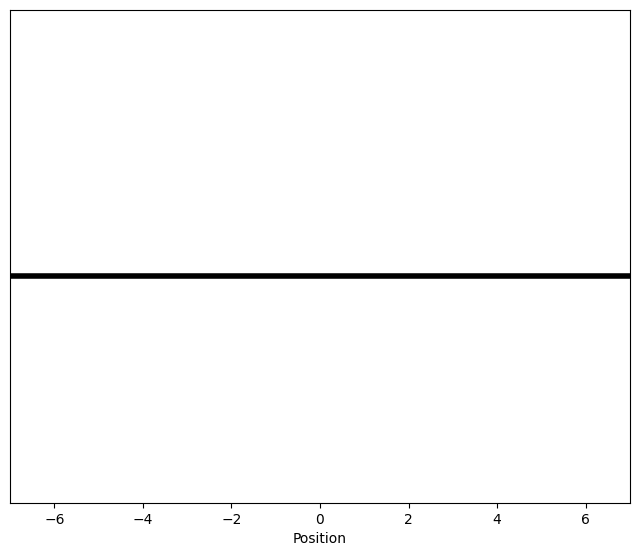

In [32]:
positions = predictions[:, 0]
angles = predictions[:, 1]

# Define the lengths from the Gekko model (adjust as necessary)
L1 = 0.5  # Length of the pendulum

# Prepare the data for the pendulum's bob and link
x1 = positions
y1 = np.zeros_like(positions)
x2 = L1 * np.sin(angles) + x1
y2 = -L1 * np.cos(angles) + y1

fig, ax = plt.subplots(figsize=(8, 6.4))
ax.set_xlim(-7, 7)
ax.set_ylim(-1.25, 1.25)
ax.set_xlabel('Position')
ax.get_yaxis().set_visible(False)

crane_rail, = ax.plot([-7, 7], [-0.1, -0.1], 'k-', lw=4)
mass1, = ax.plot([], [], linestyle='None', marker='s', markersize=40, markeredgecolor='k', color='orange', markeredgewidth=2)
line1, = ax.plot([], [], 'o-', color='black', lw=4, markersize=6, markeredgecolor='k', markerfacecolor='k')

time_template = 'time = %.1fs'
time_text = ax.text(0.05, 0.9, '', transform=ax.transAxes)

def init():
    mass1.set_data([], [])
    line1.set_data([], [])
    time_text.set_text('')
    return line1, mass1, time_text

def animate(i):
    mass1.set_data([x1[i]], [y1[i] - 0.1])
    line1.set_data([x1[i], x2[i]], [y1[i], y2[i]])
    time_text.set_text(time_template % (i/100))  # Assuming i is proportional to time
    return line1, mass1, time_text

ani = animation.FuncAnimation(fig, animate, frames=len(positions), interval=40, init_func=init)

Writer = animation.writers['ffmpeg']
writer = Writer(fps=95, metadata=dict(artist='Me'), bitrate=1800)

# Save the animation to an MP4 file
ani.save('simulations/inverted_pendulum_simulation.mp4', writer=writer)